In [1]:
import os
os.chdir('../')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle

from torch.utils.data import DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

from datasets.cityscapes import Cityscapes
from datasets.bdd100k import BDD100KSeg
from datasets.road_anomaly import RoadAnomaly
from datasets.fishyscapes import FishyscapesLAF, FishyscapesStatic
from datasets.segment_me_if_you_can import RoadAnomaly21, RoadObstacle21
from easydict import EasyDict as edict
from torch.utils.data import DataLoader
from torchmetrics import JaccardIndex

from tqdm.notebook import tqdm

from train_net import Trainer, setup
from detectron2.checkpoint import DetectionCheckpointer


from analysis.max_logits import MaxLogitsAnalyzer, OODEvaluator

# Paths

Here subscript $bi$ refers to the $i^{th}$ checkpoint before the last. This means that b1 is the checkpoint that was saved right before the final one was saved and so on. A checkpoint is saved every 5000 iterations.

In [4]:
config_path = 'model_logs/mask2former_per_pixel/config.yaml'
ckpt_path = 'model_logs/mask2former_per_pixel/model_0039999.pth'
ckpt_path_b1 = 'model_logs/mask2former_per_pixel/model_0084999.pth'
ckpt_path_b2 = 'model_logs/mask2former_per_pixel/model_0079999.pth'

ckpt_paths = {
    'final': ckpt_path,
    'b1': ckpt_path_b1,
    'b2': ckpt_path_b2,
}


# Loading the Model

In [5]:
def load_model_state_dict(path):
    with open(path, 'rb') as f:
        state_dict = pickle.load(f)
    
    return state_dict['model']

def get_model(name='final'):
    
    args = edict({'config_file': config_path, 'eval-only':True, 'opts':[]})
    config = setup(args)

    model = Trainer.build_model(config)
    DetectionCheckpointer(model, save_dir=config.OUTPUT_DIR).resume_or_load(
        ckpt_paths[name], resume=False
    )
    model.cuda()
    _ = model.eval()
    
    return model


In [6]:
model = get_model('final')

[08/29 12:01:40 detectron2]: Rank of current process: 0. World size: 1
[08/29 12:01:41 detectron2]: Environment info:
----------------------  ----------------------------------------------------------------------------------------------
sys.platform            linux
Python                  3.8.13 (default, Mar 28 2022, 11:38:47) [GCC 7.5.0]
numpy                   1.23.2
detectron2              0.6 @/home/user/anaconda3/envs/maskformer_env/lib/python3.8/site-packages/detectron2
Compiler                GCC 7.3
CUDA compiler           CUDA 11.1
detectron2 arch flags   3.7, 5.0, 5.2, 6.0, 6.1, 7.0, 7.5, 8.0, 8.6
DETECTRON2_ENV_MODULE   <not set>
PyTorch                 1.9.0+cu111 @/home/user/anaconda3/envs/maskformer_env/lib/python3.8/site-packages/torch
PyTorch debug build     False
GPU available           Yes
GPU 0                   NVIDIA GeForce RTX 3090 (arch=8.6)
Driver version          515.65.01
CUDA_HOME               /usr/local/cuda
Pillow                  9.2.0
torchvision     

[08/29 12:01:41 detectron2]: Running with full config:
CUDNN_BENCHMARK: false
DATALOADER:
  ASPECT_RATIO_GROUPING: true
  FILTER_EMPTY_ANNOTATIONS: true
  NUM_WORKERS: 6
  REPEAT_THRESHOLD: 0.0
  SAMPLER_TRAIN: TrainingSampler
DATASETS:
  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
  PROPOSAL_FILES_TEST: []
  PROPOSAL_FILES_TRAIN: []
  TEST:
  - cityscapes_fine_sem_seg_val
  TRAIN:
  - cityscapes_fine_sem_seg_train
GLOBAL:
  HACK: 1.0
INPUT:
  COLOR_AUG_SSD: true
  CROP:
    ENABLED: true
    SINGLE_CATEGORY_MAX_AREA: 1.0
    SIZE:
    - 512
    - 1024
    TYPE: absolute
  DATASET_MAPPER_NAME: mask_former_semantic
  FORMAT: RGB
  IMAGE_SIZE: 1024
  MASK_FORMAT: polygon
  MAX_SCALE: 2.0
  MAX_SIZE_TEST: 2048
  MAX_SIZE_TRAIN: 4096
  MIN_SCALE: 0.1
  MIN_SIZE_TEST: 1024
  MIN_SIZE_TRAIN:
  - 512
  - 614
  - 716
  - 819
  - 921
  - 1024
  - 1126
  - 1228
  - 1331
  - 1433
  - 1536
  - 1638
  - 1740
  - 1843
  - 1945
  - 2048
  MIN_SIZE_TRAIN_SAMPLING: choi

[08/29 12:01:41 detectron2]: Full config saved to ./model_logs/mask2former_per_pixel/config.yaml
[08/29 12:01:41 d2.utils.env]: Using a generated random seed 41770470
[08/29 12:01:44 d2.engine.defaults]: Model:
SemanticSegmentor(
  (backbone): D2SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0): BasicLayer(
        (blocks): ModuleList(
          (0): SwinTransformerBlock(
            (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=128, out_features=384, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=128, out_features=128, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softma

[08/29 12:01:44 fvcore.common.checkpoint]: [Checkpointer] Loading from model_logs/mask2former_per_pixel/model_0039999.pth ...


# Dataset Configs

In [7]:
bdd100k_config = edict({
    'seg_downsample_rate': 1,
    'train_file': 'train_paths.txt',
    'val_file': 'val_paths.txt',
    'val_image_strategy': 'no_change',
    'ignore_train_class': True,
    'dataset_root': '/home/user/datasets/bdd100k/seg'
})

cityscapes_config = edict({
    'dataset_root': '/home/user/datasets/cityscapes',
})

road_anomaly_config = edict({
    'dataset_root': '/home/user/datasets/RoadAnomaly/RoadAnomaly_jpg',
    'test_image_strategy': 'no_change'
})

fishyscapes_laf_config = edict({
    'dataset_root': '/home/user/datasets/Fishyscapes/',
})

fishyscapes_static_config = edict({
    'dataset_root': '/home/user/datasets/Fishyscapes/',
})

road_anomaly_21_config = edict({
    'dataset_root': '/home/user/datasets/SegmentMeIfYouCan/dataset_AnomalyTrack',
    'dataset_mode': 'all'
})

road_obstacle_21_config = edict({
    'dataset_root': '/home/user/datasets/SegmentMeIfYouCan/dataset_ObstacleTrack',
    'dataset_mode': 'all'
})



# Create Datasets

In [8]:
# Cityscapes
transform = A.Compose([
    ToTensorV2()
])
cityscapes_dataset = Cityscapes(cityscapes_config, transform=transform, split='val', 
                                target_type='semantic')
loader_cityscapes = DataLoader(cityscapes_dataset, batch_size=1, shuffle=False, num_workers=15)

# BDD100K
transform_bdd100k = A.Compose([
    ToTensorV2(),
])
bdd100k_dataset = BDD100KSeg(hparams=bdd100k_config, mode='val', transforms=transform_bdd100k, 
                             image_size=(720, 1280))
loader_bdd100k = DataLoader(bdd100k_dataset, batch_size=1, shuffle=False, num_workers=15)
# Road Anomaly
transform_road_anomaly = A.Compose([
    ToTensorV2()
])
road_anomaly_dataset = RoadAnomaly(hparams=road_anomaly_config, transforms=transform_road_anomaly)
loader_road_anomaly = DataLoader(road_anomaly_dataset, batch_size=1, shuffle=False, num_workers=15)

# Fishyscapes LaF
transform_fs_laf = A.Compose([
    ToTensorV2()
])
fs_laf_dataset = FishyscapesLAF(hparams=fishyscapes_laf_config, transforms=transform_fs_laf)
loader_fs_laf = DataLoader(fs_laf_dataset, batch_size=1, shuffle=False, num_workers=15)

# Fishyscapes Static
transform_fs_static = A.Compose([
    ToTensorV2()
])
fs_static_dataset = FishyscapesStatic(hparams=fishyscapes_static_config, transforms=transform_fs_static)
loader_fs_static = DataLoader(fs_static_dataset, batch_size=1, shuffle=False, num_workers=15)

# Road Anomaly 21
transform_ra_21 = A.Compose([
    A.Resize(height=720, width=1280),
    ToTensorV2()
])
road_anomaly_21_dataset = RoadAnomaly21(hparams=road_anomaly_21_config, transforms=transform_ra_21)
loader_road_anomaly_21 = DataLoader(road_anomaly_21_dataset, batch_size=1, shuffle=False, num_workers=15)


# Util Functions

In [9]:
def get_logits(model, x, **kwargs):
    
    with torch.no_grad():
        out = model([{"image": x[0].cuda()}])
        
    return out[0]['sem_seg'].unsqueeze(0)

# Closed-Set Evaluation

In [10]:
analyzer = MaxLogitsAnalyzer(model=model, inference_func=get_logits)

## Cityscapes mIoU

In [11]:
mIoU_cityscapes = analyzer.evaluate_mIoU(
    dataset=cityscapes_dataset,
    num_classes=20, 
    ignore_index=19, 
    batch_size=1,
    device=torch.device('cuda'),
    num_workers=15
 )

  0%|                                                   | 0/500 [00:00<?, ?it/s]/home/user/anaconda3/envs/maskformer_env/lib/python3.8/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
100%|█████████████████████████████████████████| 500/500 [02:17<00:00,  3.64it/s]


In [12]:
mIoU_cityscapes

tensor(0.8230)

## BDD100K mIoU

In [17]:
mIoU_bdd100k = analyzer.evaluate_mIoU(
    dataset=bdd100k_dataset,
    num_classes=20, 
    ignore_index=19, 
    batch_size=1,
    device=torch.device('cuda'),
    num_workers=15
 )

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:15<00:00,  7.39it/s]


In [18]:
mIoU_bdd100k

tensor(0.5874)

# OOD Evaluation

In [13]:
ood_evaluator = OODEvaluator(model, get_logits)

## Road Anomaly

In [14]:
anomaly_score_ra, ood_gts_ra, preds_ra = ood_evaluator.compute_max_logit_scores(
    loader=loader_road_anomaly,
    device=torch.device('cuda'),
    return_preds=True,
)

metrics_ra = ood_evaluator.evaluate_ood(
    anomaly_score=anomaly_score_ra,
    ood_gts=ood_gts_ra,
    verbose=True
)

Dataset Iteration: 100%|████████████████████████| 60/60 [00:08<00:00,  6.84it/s]


Max Logits: AUROC score: 0.6230032483128477
Max Logits: AUPRC score: 0.3469285221675432
Max Logits: FPR@TPR95: 0.9424319413117705


In [23]:
anomaly_score_ra[0,0].mean()

-16145.438

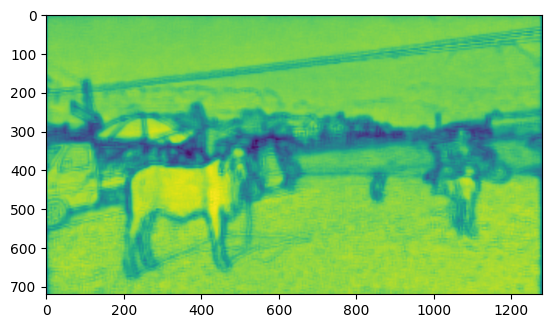

In [28]:
mn = anomaly_score_ra[0,0].min()
mx = anomaly_score_ra[0,0].max()
plt.imshow((anomaly_score_ra[0,0] - mn) / (mx - mn))
plt.show()

In [21]:
imgs_ra = ood_evaluator.get_imgs(
    road_anomaly_dataset, 
    image_mean=[0,0,0], 
    image_std=[1,1,1]
)

In [ ]:
ood_evaluator.log_to_wandb(
    project_name='road_anomaly_test',
    run_name='mask2former_swin_b_4_per_pixel_max_logit',
    imgs=imgs_ra,
    ood_gts=ood_gts_ra,
    preds=preds_ra,
    anomaly_score= anomaly_score_ra,
    class_names=bdd100k_dataset.class_names,
    metrics=metrics_ra
)

### Fishyscapes LaF

In [23]:
anomaly_score_fs_laf, ood_gts_fs_laf, preds_fs_laf = ood_evaluator.compute_max_logit_scores(
    loader=loader_fs_laf,
    device=torch.device('cuda'),
    return_preds=True,
)

metrics_fs_laf = ood_evaluator.evaluate_ood(
    anomaly_score=anomaly_score_fs_laf,
    ood_gts=ood_gts_fs_laf,
    verbose=True
)

Dataset Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.50it/s]


Max Logits: AUROC score: 0.6134254859537667
Max Logits: AUPRC score: 0.09795051573689685
Max Logits: FPR@TPR95: 0.9239928402487556


In [24]:
imgs_fs_laf = ood_evaluator.get_imgs(
    fs_laf_dataset, 
    image_mean=[0,0,0], 
    image_std=[1,1,1]
)

In [ ]:
ood_evaluator.log_to_wandb(
    project_name='fishyscapes_laf',
    run_name='mask2former_swin_b_per_pixel_max_logits',
    imgs=imgs_fs_laf,
    ood_gts=ood_gts_fs_laf,
    preds=preds_fs_laf,
    anomaly_score= anomaly_score_fs_laf,
    class_names=bdd100k_dataset.class_names,
    metrics=metrics_fs_laf
)

### Fishyscapes Static

In [26]:
anomaly_score_fs_static, ood_gts_fs_static, preds_fs_static = ood_evaluator.compute_max_logit_scores(
    loader=loader_fs_static,
    device=torch.device('cuda'),
    return_preds=True,
)

metrics_fs_static = ood_evaluator.evaluate_ood(
    anomaly_score=anomaly_score_fs_static,
    ood_gts=ood_gts_fs_static,
    verbose=True
)

Dataset Iteration: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:09<00:00,  3.22it/s]


Max Logits: AUROC score: 0.6499238610099026
Max Logits: AUPRC score: 0.28965366451868335
Max Logits: FPR@TPR95: 0.893835394149219


In [27]:
imgs_fs_static = ood_evaluator.get_imgs(
    fs_static_dataset, 
    image_mean=[0,0,0], 
    image_std=[1,1,1]
)

In [ ]:
ood_evaluator.log_to_wandb(
    project_name='fishyscapes_static',
    run_name='mask2former_swin_b_per_pixel_max_logits',
    imgs=imgs_fs_static,
    ood_gts=ood_gts_fs_static,
    preds=preds_fs_static,
    anomaly_score= anomaly_score_fs_static,
    class_names=bdd100k_dataset.class_names,
    metrics=metrics_fs_static
)

### Road Anomaly 21 (Qualitative)

In [29]:
anomaly_score_ra_21, ood_gts_ra_21, preds_ra_21 = ood_evaluator.compute_max_logit_scores(
    loader=loader_road_anomaly_21,
    device=torch.device('cuda'),
    return_preds=True,
)

Dataset Iteration: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:16<00:00,  6.83it/s]


In [30]:
imgs_ra_21 = ood_evaluator.get_imgs(
    road_anomaly_21_dataset, 
    image_mean=[0,0,0], 
    image_std=[1,1,1]
)

In [ ]:
ood_evaluator.log_to_wandb(
    project_name='road_anomaly_21',
    run_name='mask2former_swin_b_per_pixel_max_logits',
    imgs=imgs_ra_21,
    ood_gts=ood_gts_ra_21,
    preds=preds_ra_21,
    anomaly_score= anomaly_score_ra_21,
    class_names=bdd100k_dataset.class_names,
    metrics=None
)

### BDD100K (Qualitative)

In [131]:
anomaly_score_bdd100k, ood_gts_bdd100k, preds_bdd100k = ood_evaluator.compute_max_logit_scores(
    loader=loader_bdd100k,
    device=torch.device('cuda'),
    return_preds=True,
    upper_limit=450
)

Dataset Iteration:   0%|          | 0/1000 [00:00<?, ?it/s]/home/nazirnayal/anaconda3/envs/nazir_env/lib/python3.8/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/media/nazirnayal/DATA/projects/rare/OpenSetSegmentation/Mask2Former/mask2former/modeling/transformer_decoder/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use 

In [132]:
imgs_bdd100k = ood_evaluator.get_imgs(
    bdd100k_dataset, 
    image_mean=[0,0,0], 
    image_std=[1,1,1]
)

In [ ]:
ood_evaluator.log_to_wandb(
    project_name='bdd100k_anomaly_eval',
    run_name='mask2former_swin_b_replication_max_logits',
    imgs=imgs_bdd100k,
    ood_gts=ood_gts_bdd100k,
    preds=preds_bdd100k,
    anomaly_score= anomaly_score_bdd100k,
    class_names=bdd100k_dataset.class_names,
    metrics=None,
    upper_limit=450
)